In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split

import numpy as np
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.distributions import kl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"The model will be trained on {device}.")
EPS = 1e-6  # for numerical stability control

The model will be trained on cpu.


## Conventional NNs

We will perform a classification task on the "two moons" dataset. This generates two half circles that mesh together with points in each 'moon' having a corresponding label. This represents a non-linear boundary (as you will see below).

A standard fully-connected NN is used first, and then we proceed with a Bayesian NN with the same struture for comparision.



#### Load dataset

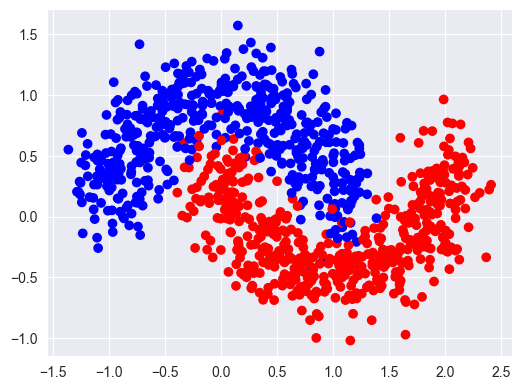

In [3]:
# Generate the moons dataset
X, Y = datasets.make_moons(1000, noise=0.20, random_state=6)

# Plot the dataset
plt.figure(figsize=(6, 4.5))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr")
sns.despine()
plt.show()

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=45)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.get_default_dtype())
X_test = torch.tensor(X_test, dtype=torch.get_default_dtype())
y_train = torch.tensor(y_train, dtype=torch.get_default_dtype()).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.get_default_dtype()).view(-1, 1)

# Set the meshgrid
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#### construct a conventional NN

Now we create the conventional NN. We start with 2 inputs, go through a series of layers, and output a single value. 

In [5]:
class ConventionalNN(nn.Module):
    def __init__(self, features):
        super(ConventionalNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.sigmoid(X)

    def loss_fn(self, X, y, reg_lambda=0., reg_ord=2):
        y_pred = self.forward(X)
        loss = F.binary_cross_entropy(y_pred, y)
        if reg_lambda == 0.:
            return loss
        else:  # We can add a regularizer here to penalize large weights.
            reg_term = sum(torch.linalg.vector_norm(param, ord=reg_ord) ** reg_ord for param in self.parameters())
            return loss + reg_lambda / y.shape[0] * reg_term

    @torch.no_grad()
    def predict(self, X_test, y_test=None, batch_size=None, device=torch.device('cpu')):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            wrong = 0
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x)
                y_pred = (y_pred >= 0.5).to(torch.get_default_dtype())
                wrong += (y_pred - y).abs().sum().item()
            return 1 - wrong / len(test_dataset)
        else:
            preds = []
            for x in test_dataloader:
                y_pred = self.forward(x[0].to(device))
                preds.append(y_pred)
            return torch.cat(preds, dim=-2).to(torch.device('cpu'))

# construct NN
features = [2, 8, 16, 16, 8, 1]

mlp = ConventionalNN(features)
mlp

ConventionalNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
  )
  (sigmoid): Sigmoid()
)

#### Train NN

Now we train the NN without the regularization. This training corresponds to a Maximum Likelihood Estimation (MLE) of the parameters.

Epoch [50/1000], Loss: 0.1827
Epoch [100/1000], Loss: 0.0664
Epoch [150/1000], Loss: 0.0628
Epoch [200/1000], Loss: 0.0631
Epoch [250/1000], Loss: 0.0593
Epoch [300/1000], Loss: 0.0578
Epoch [350/1000], Loss: 0.0568
Epoch [400/1000], Loss: 0.0545
Epoch [450/1000], Loss: 0.0521
Epoch [500/1000], Loss: 0.0533
Epoch [550/1000], Loss: 0.0515
Epoch [600/1000], Loss: 0.0512
Epoch [650/1000], Loss: 0.0503
Epoch [700/1000], Loss: 0.0515
Epoch [750/1000], Loss: 0.0500
Epoch [800/1000], Loss: 0.0508
Epoch [850/1000], Loss: 0.0504
Epoch [900/1000], Loss: 0.0500
Epoch [950/1000], Loss: 0.0497
Epoch [1000/1000], Loss: 0.0496


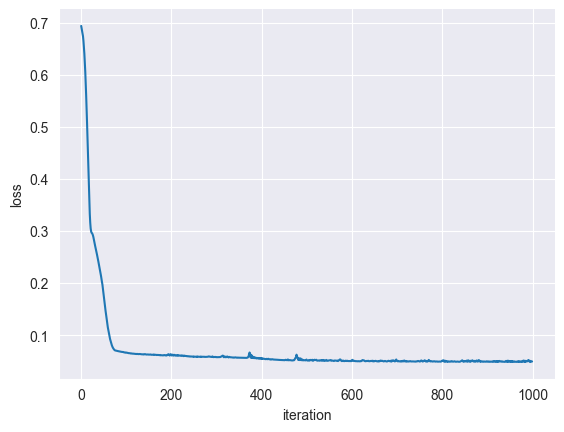

In [6]:
def train(
        model, X, y, batch_size=32, lr=0.01, reg_lambda=0., reg_ord=2,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, reg_lambda, reg_ord
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

mlp, loss_list = train(mlp, X_train, y_train, batch_size=500, lr=0.01, epochs=1000, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

Perform prediction on the test data

In [7]:
mlp.eval()
acc = mlp.predict(X_test, y_test, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

The accuracy on the test data is 96.80%


Now we plot the decision boundary

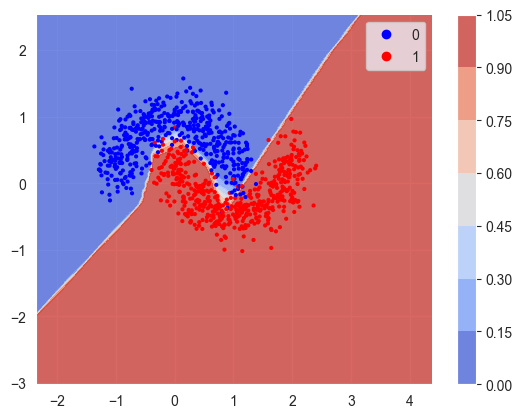

In [8]:
def plot_binary_class(X_scatters, y_scatters, xx1_grid, xx2_grid, grid_preds_mean, legend=False, color_bar=False):
    """
    Function to plot binary classification outputs.
    """
    fig, ax = plt.subplots(1, 1)

    CS = ax.contourf(xx1_grid, xx2_grid, grid_preds_mean, cmap="coolwarm", alpha=0.8)
    hs = ax.scatter(X_scatters[:, 0], X_scatters[:, 1], c=y_scatters, s=4, cmap="bwr")

    if legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_actual, labels_actual = hs.legend_elements()
        handles_actual.extend(handles)
        labels_actual.extend(labels)
        ax.legend(handles_actual, labels_actual)

    if color_bar:
        fig.colorbar(CS)

    sns.despine()


# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = mlp.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()), device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

#### How does changing the NN structure impact accuracy and decision boundaries?

Use the previously given code to create your own NN. Try changing the number of hidden layers or the number of nodes in these layers. What if you use different activation functions than just ReLu? What if you change the training epoch number?

Try to plot the decision boundaries to compare with our original implementation.

In [ ]:
#Your code here. 

Now we add an L2 regularizer to the training procedure. In such case it returns a Maximum A Posterior (MAP) estimation of the parameters.

Epoch [50/1000], Loss: 0.1661
Epoch [100/1000], Loss: 0.0741
Epoch [150/1000], Loss: 0.0696
Epoch [200/1000], Loss: 0.0682
Epoch [250/1000], Loss: 0.0663
Epoch [300/1000], Loss: 0.0645
Epoch [350/1000], Loss: 0.0639
Epoch [400/1000], Loss: 0.0624
Epoch [450/1000], Loss: 0.0616
Epoch [500/1000], Loss: 0.0625
Epoch [550/1000], Loss: 0.0597
Epoch [600/1000], Loss: 0.0597
Epoch [650/1000], Loss: 0.0583
Epoch [700/1000], Loss: 0.0582
Epoch [750/1000], Loss: 0.0579
Epoch [800/1000], Loss: 0.0580
Epoch [850/1000], Loss: 0.0568
Epoch [900/1000], Loss: 0.0561
Epoch [950/1000], Loss: 0.0593
Epoch [1000/1000], Loss: 0.0557


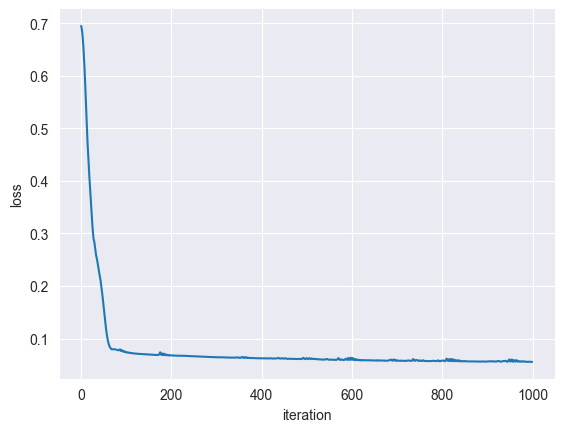

In [9]:
mlp_map = ConventionalNN(features)

mlp_map, loss_list = train(mlp_map, X_train, y_train, reg_lambda=0.1, reg_ord=2,
                           lr=0.01, batch_size=500, epochs=1000, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

The accuracy on the test data is 97.20%


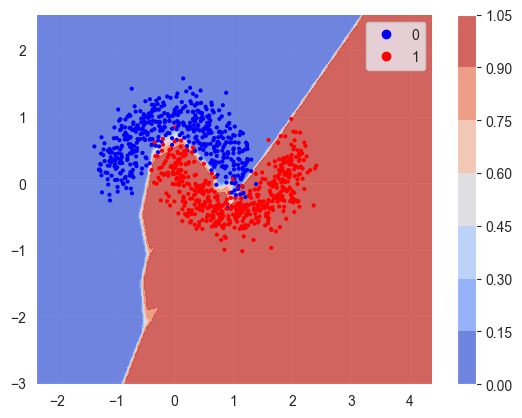

In [10]:
# Predict on test data
mlp_map.eval()
acc = mlp_map.predict(X_test, y_test, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

# Predict on grid
p = mlp_map.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()), device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

#### What if our training data is a different size?

What if we were in a situation where we did not have that much training data- how would our conventional NN perform? You should experiment with different ratios of training/testing data below to see how it impacts the decision boundaries and accuracy of our model.

In [ ]:
#Add your code to see how the decision boundary and accuracy changes as the training data size changes

# Split the dataset into training and testing sets
X_smalltrain, X_bigtest, y_smalltrain, y_bigtest = train_test_split(X, Y, test_size=0.75, random_state=45)

# Convert the data to PyTorch tensors
X_smalltrain = torch.tensor(X_smalltrain, dtype=torch.get_default_dtype())
X_bigtest = torch.tensor(X_bigtest, dtype=torch.get_default_dtype())
y_smalltrain = torch.tensor(y_smalltrain, dtype=torch.get_default_dtype()).view(-1, 1)
y_bigtest = torch.tensor(y_bigtest, dtype=torch.get_default_dtype()).view(-1, 1)

# Set the meshgrid
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 2
y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


## YOUR CODE BELOW HERE

#### How do we find out uncertainty of our standard NN?

It's a good question- we want to know uncertainty for our predictions. However, there's not any obvious way to do this for a standard NN. We can use methods like MC Dropout to estimate Bayesian inference for uncertainty quantification.

Epoch [50/1000], Loss: 0.3362
Epoch [100/1000], Loss: 0.1753
Epoch [150/1000], Loss: 0.1577
Epoch [200/1000], Loss: 0.1291
Epoch [250/1000], Loss: 0.1105
Epoch [300/1000], Loss: 0.1239
Epoch [350/1000], Loss: 0.1117
Epoch [400/1000], Loss: 0.1164
Epoch [450/1000], Loss: 0.1047
Epoch [500/1000], Loss: 0.0976
Epoch [550/1000], Loss: 0.1179
Epoch [600/1000], Loss: 0.1073
Epoch [650/1000], Loss: 0.1406
Epoch [700/1000], Loss: 0.1178
Epoch [750/1000], Loss: 0.1104
Epoch [800/1000], Loss: 0.0809
Epoch [850/1000], Loss: 0.1138
Epoch [900/1000], Loss: 0.1235
Epoch [950/1000], Loss: 0.1020
Epoch [1000/1000], Loss: 0.0983
The accuracy on the test data is 96.20%


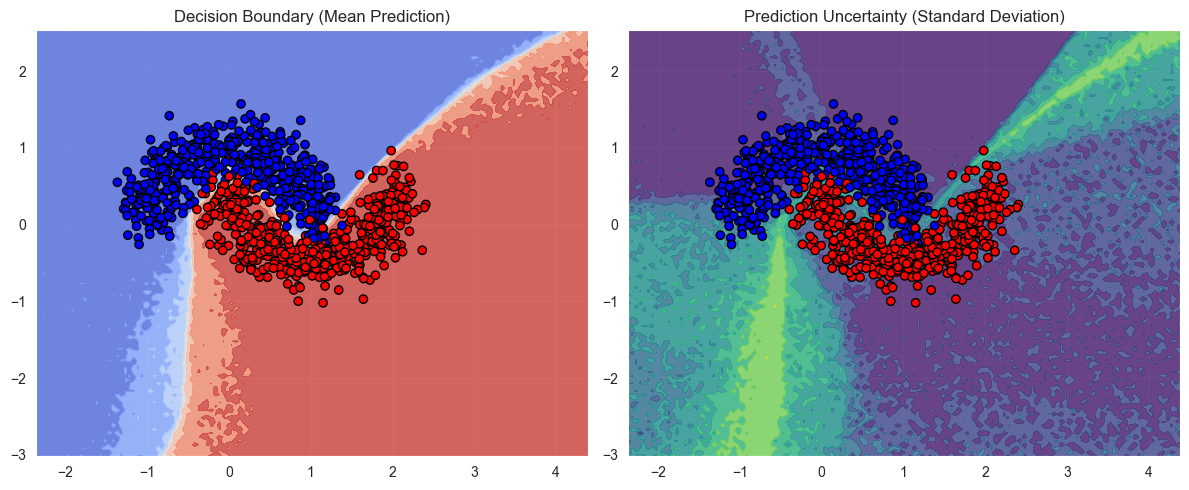

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

class MCDropoutNN(nn.Module):
    def __init__(self, features, dropout_rate=0.1):
        super(MCDropoutNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(nn.Linear(features[i], features[i+1]))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(p=dropout_rate))
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return self.sigmoid(X)

    def loss_fn(self, X, y):
        y_pred = self.forward(X)
        return F.binary_cross_entropy(y_pred, y)

    @torch.no_grad()
    def predict(self, X_test, y_test=None, num_samples=100, batch_size=None, device=torch.device('cpu')):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        self.train()  # Set to train mode to enable dropout

        if y_test is not None:
            all_preds = []
            for _ in range(num_samples):
                preds = []
                for x, y in test_dataloader:
                    x, y = x.to(device), y.to(device)
                    y_pred = self.forward(x)
                    preds.append(y_pred)
                preds = torch.cat(preds, dim=0)
                all_preds.append(preds)
            
            all_preds = torch.stack(all_preds)
            mean_preds = all_preds.mean(dim=0)
            y_pred = (mean_preds >= 0.5).float()
            
            wrong = (y_pred - y_test.to(device)).abs().sum().item()
            return 1 - wrong / len(test_dataset)
        else:
            all_preds = []
            for _ in range(num_samples):
                preds = []
                for x in test_dataloader:
                    x = x[0].to(device)
                    y_pred = self.forward(x)
                    preds.append(y_pred)
                preds = torch.cat(preds, dim=0)
                all_preds.append(preds)
            
            all_preds = torch.stack(all_preds)
            mean_preds = all_preds.mean(dim=0)
            std_preds = all_preds.std(dim=0)
            return mean_preds.cpu(), std_preds.cpu()

def train(model, X, y, batch_size=32, lr=0.01, epochs=10, print_iters=50, device=torch.device('cpu')):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataset = TensorDataset(X, y)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = model.loss_fn(inputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

# Usage example
features = [2, 8, 16, 16, 8, 1]
mc_dropout_nn = MCDropoutNN(features, dropout_rate=0.1)

# Train the model
mc_dropout_nn, loss_list = train(mc_dropout_nn, X_train, y_train, batch_size=500, lr=0.01, epochs=1000, device=device)

# Evaluate on test data
accuracy = mc_dropout_nn.predict(X_test, y_test, num_samples=100, device=device)
print(f"The accuracy on the test data is {accuracy * 100:.2f}%")

# Predict on grid with uncertainty
inputs = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)
mean_preds, std_preds = mc_dropout_nn.predict(inputs, num_samples=100, device=device)
mean_preds = mean_preds.reshape(xx.shape)
std_preds = std_preds.reshape(xx.shape)

# Plot decision boundary with uncertainty
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.contourf(xx, yy, mean_preds, cmap='coolwarm', alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', edgecolors='black')
plt.title('Decision Boundary (Mean Prediction)')

plt.subplot(122)
plt.contourf(xx, yy, std_preds, cmap='viridis', alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr', edgecolors='black')
plt.title('Prediction Uncertainty (Standard Deviation)')

plt.tight_layout()
plt.show()

#### How does the uncertainty estimation change?

How about if you change the dropout rate? Include/exclude regularisation? Try it below!

In [12]:
#Your code here

## Bayesian NNs - Prior over Weights

A BNN is a NN that uses (approximate) Bayesian inference for uncertainty estimation. We can treat the NN parameters as random variables and infer them using Bayesian posterior inference.

To begin with, we will construct a BNN layer with Gaussian priors over the weights, and then we will define a BNN.

#### Construct a Bayesian linear layer




In [13]:
class BayesianLinear(nn.Module):
    def __init__(
            self, in_features, out_features,
            prior_weight_std=0.1, prior_bias_std=0.1, lecun_init=False
    ):
        super(BayesianLinear, self).__init__()

        # Define the prior params
        prior_mean = 0.
        if lecun_init:  # LeCun initialization：prior variance scales as 1/dim_in
            prior_weight_std /= in_features ** 0.5
            prior_bias_std /= in_features ** 0.5
        # Prior parameters registered as constants
        self.register_buffer('prior_weight_mean', torch.full([out_features, in_features], prior_mean))
        self.register_buffer('prior_weight_std', torch.full([out_features, in_features], prior_weight_std))
        self.register_buffer('prior_bias_mean', torch.full([out_features], prior_mean))
        self.register_buffer('prior_bias_std', torch.full([out_features], prior_bias_std))

    def prior_forward(self, x):
        # Sample weights and biases from prior normal distributions
        prior_weight = self.prior_weight_mean + self.prior_weight_std * torch.randn_like(self.prior_weight_std)
        prior_bias = self.prior_bias_mean + self.prior_bias_std * torch.randn_like(self.prior_bias_std)
        return F.linear(x, prior_weight, prior_bias)


In [14]:
class BayesianNN(nn.Module):
    def __init__(self, features, **layer_prior_kwargs):
        super(BayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(BayesianLinear(features[i], features[i+1], **layer_prior_kwargs))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    @torch.no_grad()
    def prior_forward(self, x):
        for layer in self.layers:
            if isinstance(layer, BayesianLinear):
                x = layer.prior_forward(x)
            else:
                x = layer(x)
        return self.sigmoid(x)

#### Random functions from the prior

We then sample the prior random functions output by the BNN to see the effects of changing the prior hyperparameters. Try changing it yourself to see the impacts below!

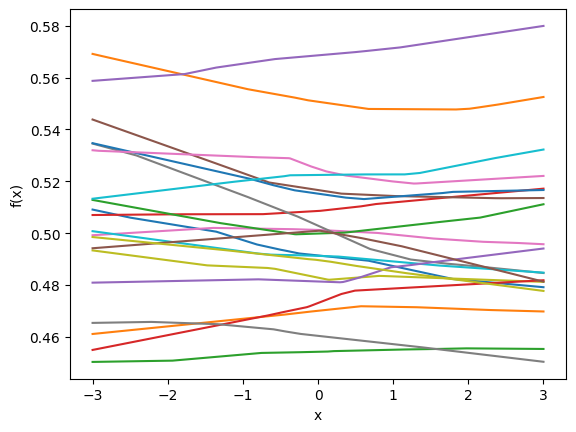

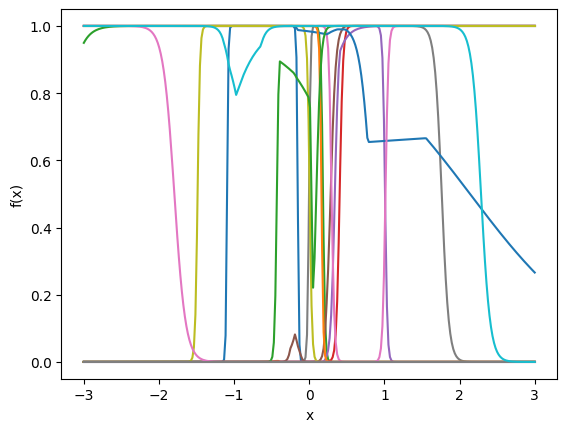

In [15]:
def sample_prior(model, num_samples, x):
    # Sample random functions
    prior_samples = []
    for _ in range(num_samples):
        sample = model.prior_forward(x)
        prior_samples.append(sample)

    # Plot samples
    for i in range(num_samples):
        plt.plot(x.numpy().reshape([-1]), prior_samples[i].numpy().reshape([-1]))

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.show()


# Construct a 2-layer BNN
features = [1, 10, 1]
BNN = BayesianNN(features)

# Plot
num_samples = 20
x = torch.linspace(-3, 3, 300).view(-1, 1)
sample_prior(BNN, num_samples, x)

# We can change the prior to see its effect on the output functions
BNN = BayesianNN(features, prior_weight_std=10., prior_bias_std=5., lecun_init=True)
sample_prior(BNN, num_samples, x)

## Inference - Posterior Approximation
This part will employ mean-field variational inference (MFVI, also known as [Bayes-by-backprop](https://arxiv.org/abs/1505.05424)) to approximate the posterior distributions of the parameters of the BNN.

### Mean-field Variational Inference (MFVI)

#### Bayesian linear layers with variational distributions

In [17]:
class MFVIBayesianLinear(BayesianLinear):  # inherit
    def __init__(
            self, in_features, out_features,
            init_std=0.1, **layer_prior_kwargs
    ):
        super(MFVIBayesianLinear, self).__init__(in_features, out_features, **layer_prior_kwargs)

        # Mean and log variance for weights and biases of variational distributions
        self.weight_mean = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_logstd = nn.Parameter(torch.ones(out_features, in_features))
        self.bias_mean = nn.Parameter(torch.zeros(out_features))
        self.bias_logstd = nn.Parameter(torch.ones(out_features))

        # initialization
        self.reset_params(in_features, init_std)

    def reset_params(self, in_features, init_std):
        # initialization
        nn.init.kaiming_uniform_(self.weight_mean)
        bound = 1 / in_features ** 0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)
        nn.init.constant_(self.weight_logstd, math.log(init_std + EPS))
        nn.init.constant_(self.bias_logstd, math.log(init_std + EPS))

    @property
    def weight_std(self):
        return torch.exp(self.weight_logstd)

    @property
    def bias_std(self):
        return torch.exp(self.bias_logstd)

    def forward(self, x, sample_shape=torch.Size([])):  # Sample weights and biases from normal distributions
        # weight = self.weight_mean + self.weight_std * torch.randn_like(self.weight_std)
        # bias = self.bias_mean + self.bias_std * torch.randn_like(self.bias_std)
        # return F.linear(x, weight, bias)
        weight = Normal(self.weight_mean, self.weight_std).rsample(sample_shape)
        bias = Normal(self.bias_mean, self.bias_std).rsample(sample_shape)
        return x @ weight.mT + bias.unsqueeze(-2)

    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q_weight = Normal(self.weight_mean, self.weight_std)
        p_weight = Normal(self.prior_weight_mean, self.prior_weight_std)
        q_bias = Normal(self.bias_mean, self.bias_std)
        p_bias = Normal(self.prior_bias_mean, self.prior_bias_std)
        return kl.kl_divergence(q_weight, p_weight).sum() + kl.kl_divergence(q_bias, p_bias).sum()


In [18]:
class MFVIBayesianNN(nn.Module):
    def __init__(self, features, init_std=0.1, **layer_prior_kwargs):
        super(MFVIBayesianNN, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(features) - 1):
            self.layers.append(MFVIBayesianLinear(features[i], features[i+1], init_std, **layer_prior_kwargs))
            if i != len(features) - 2:
                self.layers.append(nn.ReLU())
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, sample_shape=torch.Size([])):
        for layer in self.layers:
            x = layer(x, sample_shape) if isinstance(layer, MFVIBayesianLinear) else layer(x)
        return self.sigmoid(x)

    def expected_log_prob(self, X, y, num_samples=1):
        y_pred = self.forward(X, torch.Size([num_samples])).mean(dim=0)
        loss = F.binary_cross_entropy(y_pred, y, reduction='mean')
        return - loss

    # collect the kl divergence for all MFVILinear layers
    def kl_divergence(self):
        kl = 0.
        for layer in self.layers:
            if isinstance(layer, MFVIBayesianLinear):
                kl = kl + layer.kl_divergence()
        return kl

    def loss_fn(self, X, y, num_data, num_samples=1, tempered=1.):
        data_fit = self.expected_log_prob(X, y, num_samples)
        kl = self.kl_divergence() * tempered / num_data
        return - (data_fit - kl)

    @torch.no_grad()
    def predict(
            self, X_test, y_test=None, num_samples=1,
            batch_size=None, device=torch.device('cpu')
    ):
        test_dataset = TensorDataset(X_test, y_test) if y_test is not None else TensorDataset(X_test)
        batch_size = len(test_dataset) if batch_size is None else batch_size
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        self.to(device)
        if y_test is not None:
            preds = []
            for x, y in test_dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x, torch.Size([num_samples])).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            y_pred = (preds >= 0.5).to(torch.get_default_dtype())

            print(f"{y_pred.device}, {y_test.device}")

            wrong = (y_pred - y_test).abs().sum().item()
            return 1 - wrong / len(test_dataset)

        else:
            preds = []
            for x in test_dataloader:
                x = x[0].to(device)
                y_pred = self.forward(x, torch.Size([num_samples])).mean(dim=0)
                preds.append(y_pred)
            preds = torch.cat(preds, dim=-2)
            return preds.to(torch.device('cpu'))

In [19]:
# Construct a BNN with the same structure
features = [2, 8, 16, 16, 8, 1]
init_std = 0.01
layer_prior_kwargs = {
    'prior_weight_std': 1,
    'prior_bias_std': 1,
    'lecun_init': True
}
bnn = MFVIBayesianNN(features, init_std, **layer_prior_kwargs)
bnn

MFVIBayesianNN(
  (layers): ModuleList(
    (0): MFVIBayesianLinear()
    (1): ReLU()
    (2): MFVIBayesianLinear()
    (3): ReLU()
    (4): MFVIBayesianLinear()
    (5): ReLU()
    (6): MFVIBayesianLinear()
    (7): ReLU()
    (8): MFVIBayesianLinear()
  )
  (sigmoid): Sigmoid()
)

#### Train BNN

In [ ]:
def train(
        model, X, y, batch_size=32, lr=0.01, num_samples=100, tempered=1.,
        epochs=10, print_iters=50, device=torch.device('cpu')
):
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # DataLoader for batching
    dataset = TensorDataset(X, y)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()  # Set model to training mode
    model.to(device)

    losses = []
    for epoch in range(epochs):
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()                 # Zero the gradient
            loss = model.loss_fn(
                inputs, labels, num_data=len(dataset),
                num_samples=num_samples, tempered=tempered
            )                                     # Loss function (CrossEntropyLoss in this case)
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update weights
            losses.append(loss.item())

        if (epoch + 1) % print_iters == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return model, losses

# Train the BNN
bnn, loss_list = train(bnn, X_train, y_train, batch_size=500, lr=0.01, num_samples=10, tempered=1,
                       epochs=1500, print_iters=100, device=device)

plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
sns.despine()

cpu, cpu
The accuracy on the test data is 96.60%


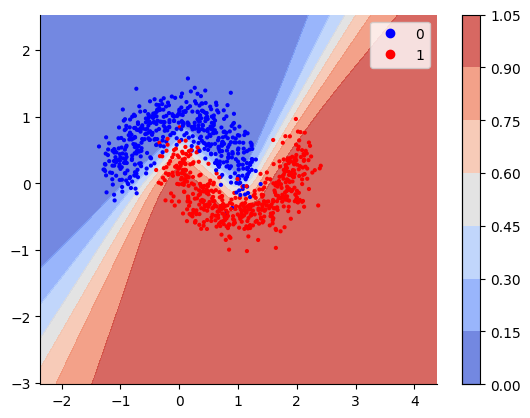

In [21]:
# Predict on test data
bnn.eval()
acc = bnn.predict(X_test, y_test, num_samples=100, device=device)

print(f"The accuracy on the test data is {acc * 100:.2f}%")

# Predict on grid
inputs = np.stack([xx.ravel(), yy.ravel()], axis=-1)
p = bnn.predict(torch.as_tensor(inputs, dtype=torch.get_default_dtype()),
                num_samples=100, device=device)
p = p.reshape(xx.shape)

plot_binary_class(X, Y, xx, yy, p, legend=True, color_bar=True)

#### How does our BNN compare with our NN? 

You might see that on our original data set splits, the BNN does not greatly outperform the conventional NN. How does the difference change as the training data split change? Can we achieve similar BNN accuracy to our NN approach when our BNN has fewer nodes in layers or even fewer layers? Establish this below:

In [ ]:
#Your code here!

### Last-layer BNN with full-rank Gaussian approximation

MCMC Methods？

## Bayesian CNN - more complex structure